Michael Muschitiello // Eigenvalue Decomposition of S&P500

- This notebook explores the relationship between S&P 500 constituents' returns and market capitalizations.  
- It focuses on eigenvalue decomposition of the covariance matrix to examine dimensionality and risk factors, and evaluates market diversity and concentration through measures such as Shannon entropy and effective rank. Key steps in this workflow include:

1. **Data Import & Cleaning**  
   - Pulls 2 years of weekly price data via yfinance for the S&P 500 constituents,  
     removing tickers without sufficient data.  

2. **Log Returns & Covariance Matrix**  
   - Computes weekly log returns for valid tickers.  
   - Constructs a covariance matrix suitable for eigenvalue decomposition.  

3. **Eigenvalues & Eigenvectors**  
   - Decomposes the covariance matrix to explore principal components (risk factors).  
   - Visualizes the distribution of eigenvalues via a scree plot to illustrate how much variance is captured by each factor.

4. **Shannon Entropy & Effective Rank**  
   - Normalizes eigenvalues to probabilities.  
   - Computes the Shannon entropy of the eigenvalues.  
   - Derives an effective rank, reflecting the number of independent risk factors.  

5. **Market-Cap Diversity**  
   - Imports S&P 500 index market caps as of Jan 31, 2025.  
   - Computes Shannon entropy on these weights to measure market concentration vs. uniform distribution.  

6. **Serial Correlation Test**  
   - Runs a Ljung-Box test on each ticker’s returns to check for autocorrelation at various lags.  

All of these analyses inform how many distinct dimensions drive market behavior, while also highlighting  
how concentrated or diversified the market is, both in terms of return correlations and market capitalization.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf 
import seaborn as sns 

from statsmodels.stats.diagnostic import acorr_ljungbox


Using MarketCaps as of 1/31/2025

In [2]:
sp_data = pd.read_excel('S&P 500 1-31-25.xlsx', sheet_name='20250131_SP500_CLS')
sp_data = sp_data[['BLOOMBERG TICKER', 'INDEX MARKET CAP']]
sp_data.dropna(inplace=True)
sp_data

,BLOOMBERG TICKER,INDEX MARKET CAP
0,AAPL UQ,3.567334e+12
1,MSFT UQ,3.085922e+12
2,NVDA UQ,2.945317e+12
3,AMZN UQ,2.224295e+12
4,META UQ,1.502413e+12
...,...,...
499,FOX UQ,6.411572e+09
500,MHK UN,6.407350e+09
501,BF/B UN,6.011854e+09
502,NWS UQ,3.543670e+09


In [3]:
sp_data['BLOOMBERG TICKER'] = sp_data['BLOOMBERG TICKER'].str.replace(' UQ', '', regex=True)
sp_data['BLOOMBERG TICKER'] = sp_data['BLOOMBERG TICKER'].str.replace(' UN', '', regex=False)
sp_data['BLOOMBERG TICKER'] = sp_data['BLOOMBERG TICKER'].str.replace(' UW', '', regex=False)
sp_data['BLOOMBERG TICKER'] = sp_data['BLOOMBERG TICKER'].str.replace(' UP', '', regex=False)
sp_data['BLOOMBERG TICKER'] = sp_data['BLOOMBERG TICKER'].str.replace(' UR', '', regex=True)
sp_data['BLOOMBERG TICKER'] = sp_data['BLOOMBERG TICKER'].str.replace('/', '-', regex=False)
sp_data  

,BLOOMBERG TICKER,INDEX MARKET CAP
0,AAPL,3.567334e+12
1,MSFT,3.085922e+12
2,NVDA,2.945317e+12
3,AMZN,2.224295e+12
4,META,1.502413e+12
...,...,...
499,FOX,6.411572e+09
500,MHK,6.407350e+09
501,BF-B,6.011854e+09
502,NWS,3.543670e+09


In [4]:
tickers = sp_data['BLOOMBERG TICKER'].to_list()
len(tickers)

504

Downloading 5y of weekly data for all constituents of the S&P500

In [5]:
price_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, period = '2y', interval = '1wk', auto_adjust=False)['Close']
    log_returns = np.log(data/data.shift(1))
    price_data = pd.concat([price_data, log_returns], axis=1)
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

**no data found for 'UF', 'LEN', 'ETR'**

In [6]:
#price_data.dropna(axis=0, how='all', inplace=True)
price_data.dropna(axis=1, how='all', inplace=True)
price_data 

Ticker,AAPL,MSFT,NVDA,AMZN,META,GOOGL,TSLA,AVGO,GOOG,BRK-B,...,WBA,BWA,FMC,BEN,PARA,FOX,MHK,BF-B,NWS,MRP
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-27,0.029021,0.024064,0.025608,0.014862,0.083616,0.049468,0.004611,0.090950,0.050946,0.027351,...,0.008068,0.020480,-0.003654,0.010190,0.012921,-0.026358,0.023097,0.030907,-0.010274,NaN
2023-03-06,-0.016894,-0.026595,-0.039489,-0.044936,-0.031475,-0.032779,-0.131374,-0.028745,-0.032538,-0.028635,...,-0.081660,-0.058143,-0.063003,-0.070708,-0.127290,-0.053912,-0.083847,-0.085778,-0.074417,NaN
2023-03-13,0.042840,0.116947,0.113492,0.086727,0.085892,0.114455,0.037847,0.025912,0.118503,-0.033898,...,-0.010579,-0.046977,-0.037954,-0.048301,-0.009598,-0.013529,-0.036629,0.002273,-0.007444,NaN
2023-03-20,0.033310,0.004071,0.040155,-0.008322,0.051802,0.036902,0.055501,0.008208,0.034532,0.018264,...,-0.006401,0.035227,0.013861,0.000761,0.026548,0.009259,0.011067,0.020705,0.017284,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-20,-0.031808,0.034433,0.035034,0.038678,0.055114,0.021252,-0.047832,0.030118,0.021781,-0.010224,...,-0.053313,0.011087,0.039091,0.026736,0.075012,0.019304,-0.031192,-0.010849,0.038081,NaN
2025-01-27,0.057647,-0.067537,-0.172109,0.011978,0.062399,0.018851,-0.004882,-0.100649,0.018160,0.011762,...,-0.143814,-0.023239,0.003952,0.101670,-0.017312,0.043097,-0.024234,-0.027194,0.002214,NaN
2025-02-03,-0.036110,-0.012876,0.078228,-0.036548,0.036109,-0.096026,-0.112305,0.016139,-0.094076,0.008647,...,-0.015687,-0.060742,-0.479297,-0.084888,-0.023246,0.030397,-0.016239,-0.067998,0.069267,NaN


In [7]:
log_returns = price_data

## Ljung-Box Test

In [8]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

def get_significant_lags(df, alpha=0.05, lags=range(1, 21)):
    """
    For each column in a DataFrame of log returns, run the Ljung-Box test
    across the specified lag periods and return a dictionary with only the
    significant lags (those with p-value < alpha).
    
    Args:
        df (pd.DataFrame): DataFrame where each column is a log return series.
        alpha (float): Significance level for the test. Default is 0.05.
        lags (iterable): Lags at which to run the test. Default is range(1, 21).
        
    Returns:
        dict: A dictionary where keys are df column names and values are DataFrames
              with the Ljung-Box test results for lags that are statistically significant,
              or None if no lags are significant.
    """
    significant_results = {}
    
    for col in df.columns:
        # drop NA values from the series
        series = df[col].dropna()
        
        # run the Ljung-Box test for all specified lags
        lb_test = acorr_ljungbox(series, lags=lags, return_df=True)
        
        # filter for significant p-values (p < alpha)
        sig = lb_test[lb_test['lb_pvalue'] < alpha]
        
        # Store the result (None if no significant lags found)
        if not sig.empty:
            significant_results[col] = sig
        else:
            significant_results[col] = None
            
    return significant_results


sig_lags = get_significant_lags(log_returns, alpha=0.05, lags=range(1,21))

# print results for each column
for col, result in sig_lags.items():
    print(f"Significant lags for {col}:")
    if result is not None:
        print(result)
    else:
        print("No significant serial correlation found.")
    print("\n")

Significant lags for AAPL:
No significant serial correlation found.


Significant lags for MSFT:
No significant serial correlation found.


Significant lags for NVDA:
No significant serial correlation found.


Significant lags for AMZN:
No significant serial correlation found.


Significant lags for META:
No significant serial correlation found.


Significant lags for GOOGL:
No significant serial correlation found.


Significant lags for TSLA:
No significant serial correlation found.


Significant lags for AVGO:
No significant serial correlation found.


Significant lags for GOOG:
No significant serial correlation found.


Significant lags for BRK-B:
No significant serial correlation found.


Significant lags for JPM:
No significant serial correlation found.


Significant lags for LLY:
No significant serial correlation found.


Significant lags for V:
      lb_stat  lb_pvalue
1    3.971442   0.046278
2    6.308859   0.042663
3    8.387775   0.038642
4   10.372217   0.034603
5   15.7292

c:\Users\musch\anaconda3\Lib\site-packages\statsmodels\stats\diagnostic.py:463: RuntimeWarning: divide by zero encountered in divide
  sacf2 = sacf[1:maxlag + 1] ** 2 / (nobs - np.arange(1, maxlag + 1))


We have some serial correlation, but should not affect us here

In [9]:
nan_counts = log_returns.isna().sum()
nan_counts[nan_counts > 0]

Ticker
AAPL      1
MSFT      1
NVDA      1
AMZN      1
META      1
       ... 
FOX       1
MHK       1
BF-B      1
NWS       1
MRP     103
Length: 502, dtype: int64

Going to drop columns with 100+ missing data points and ffill and bfill the rest

In [10]:
# ID columns with more than 100 NaN values and drop 
cols_to_drop = nan_counts[nan_counts > 100].index
log_returns = log_returns.drop(columns=cols_to_drop)

# ffill, bfill
log_returns = log_returns.ffill().bfill()

# compute cov matrix
cov_matrix = np.cov(log_returns, rowvar=False)
cov_matrix

array([[9.47722079e-04, 3.82277409e-04, 6.87763726e-04, ...,
        1.04642277e-04, 2.50869709e-04, 3.79855006e-05],
       [3.82277409e-04, 8.38707533e-04, 1.18697047e-03, ...,
        7.83615532e-05, 2.44682471e-04, 1.42863778e-04],
       [6.87763726e-04, 1.18697047e-03, 4.19942403e-03, ...,
        6.41485497e-04, 4.07956223e-05, 3.87447256e-04],
       ...,
       [1.04642277e-04, 7.83615532e-05, 6.41485497e-04, ...,
        3.10267479e-03, 7.28383676e-04, 7.17153820e-04],
       [2.50869709e-04, 2.44682471e-04, 4.07956223e-05, ...,
        7.28383676e-04, 1.22730569e-03, 1.25840280e-04],
       [3.79855006e-05, 1.42863778e-04, 3.87447256e-04, ...,
        7.17153820e-04, 1.25840280e-04, 9.45614343e-04]])

In [11]:
# compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print("Covariance Matrix:", cov_matrix, sep="\n")
print("\nEigenvalues:", eigenvalues, sep="\n")
print("\nEigenvectors:", eigenvectors, sep="\n")

Covariance Matrix:
[[9.47722079e-04 3.82277409e-04 6.87763726e-04 ... 1.04642277e-04
  2.50869709e-04 3.79855006e-05]
 [3.82277409e-04 8.38707533e-04 1.18697047e-03 ... 7.83615532e-05
  2.44682471e-04 1.42863778e-04]
 [6.87763726e-04 1.18697047e-03 4.19942403e-03 ... 6.41485497e-04
  4.07956223e-05 3.87447256e-04]
 ...
 [1.04642277e-04 7.83615532e-05 6.41485497e-04 ... 3.10267479e-03
  7.28383676e-04 7.17153820e-04]
 [2.50869709e-04 2.44682471e-04 4.07956223e-05 ... 7.28383676e-04
  1.22730569e-03 1.25840280e-04]
 [3.79855006e-05 1.42863778e-04 3.87447256e-04 ... 7.17153820e-04
  1.25840280e-04 9.45614343e-04]]

Eigenvalues:
[ 2.05008580e-01+0.00000000e+00j  6.11036279e-02+0.00000000e+00j
  3.51217667e-02+0.00000000e+00j  2.70712620e-02+0.00000000e+00j
  2.46418000e-02+0.00000000e+00j  2.24314572e-02+0.00000000e+00j
  1.86562293e-02+0.00000000e+00j  1.72467618e-02+0.00000000e+00j
  1.62094842e-02+0.00000000e+00j  1.54175539e-02+0.00000000e+00j
  1.42397291e-02+0.00000000e+00j  1.339115

In [12]:
len(eigenvalues), len(log_returns.columns)

(501, 501)

-----------------------------------------------------------

# Scree Plot of Eigenvalues

A scree plot is an essential visual tool used in eigenvalue analysis, particularly in principal component analysis (PCA) or factor analysis. It plots the eigenvalues in descending order, and here's why it's valuable:

- **Identifying Significant Components:**  
  The scree plot helps to visually determine the "elbow" point where the eigenvalues begin to level off. This indicates that subsequent components contribute only marginally to the total variance, suggesting that most of the important structure in the data is captured by the components before the elbow.

- **Dimensionality Reduction:**  
  By revealing which eigenvalues (and corresponding eigenvectors) account for the majority of the variance, the scree plot aids in selecting a reduced number of principal components. This reduces the complexity of the model while retaining most of the information.

- **Distinguishing Signal from Noise:**  
  Larger eigenvalues correspond to directions in the data with significant variance (signal), whereas smaller eigenvalues often represent noise. The plot makes it clear which components are worth keeping and which can be ignored.

- **Determining Effective Rank:**  
  In financial applications, such as analyzing a covariance matrix of stock returns, the scree plot can provide insights into the number of independent risk factors present. This effective rank can be crucial for risk management and portfolio optimization.

Overall, the scree plot is a straightforward graphical method to understand the variance distribution across different components, guiding decisions on how many dimensions (or factors) to retain in the analysis.


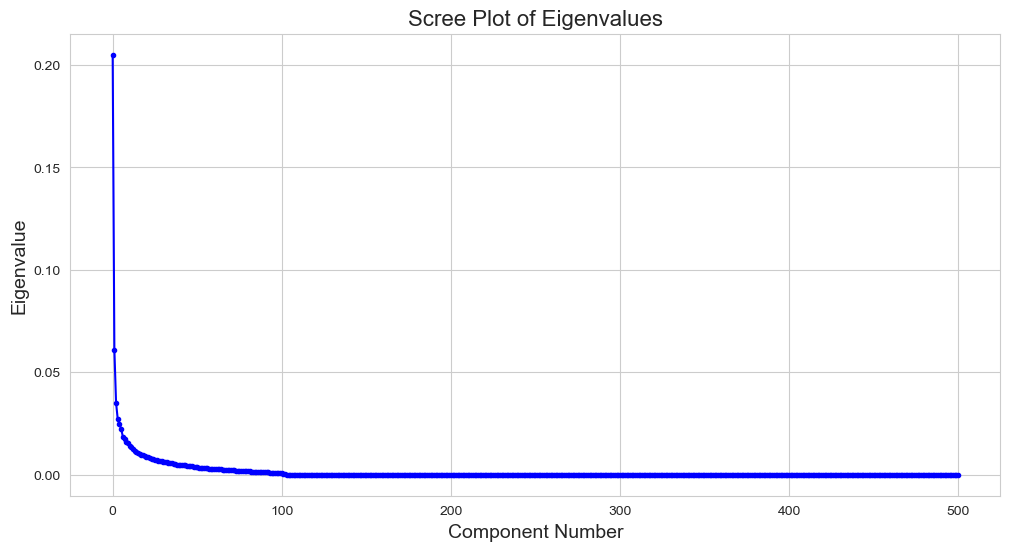

In [13]:
# Discard any negligible imaginary parts: take real part only
eigenvalues = np.real(eigenvalues)

# Sort eigenvalues in descending order
sorted_eigenvalues = np.sort(eigenvalues)[::-1]


sns.set_style('whitegrid')
# scree plot of the eigenvalues
plt.figure(figsize=(12, 6))
plt.plot(sorted_eigenvalues, marker='o', linestyle='-', color='b', markersize=3)
plt.title('Scree Plot of Eigenvalues', fontsize=16)
plt.xlabel('Component Number', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.grid(True)
plt.show()

---------------------------------------------------------------------------------
# Calculating Effective Rank

Given a set of eigenvalues from a covariance matrix:

$$
\lambda_1, \lambda_2, \dots, \lambda_n
$$

1. **Normalize the eigenvalues to obtain probabilities:**

   $$
   p_i = \frac{\lambda_i}{\sum_{j=1}^{n} \lambda_j}
   $$

2. **Compute the Shannon entropy:**

   $$
   H = -\sum_{i=1}^{n} p_i \log(p_i)
   $$

   *Note:* The computation safely handles cases where $p_i=0$ (since $0\log(0)$ is treated as $0$).

3. **Compute the effective rank:**

   $$
   \text{Effective Rank} = \exp(H) = \exp\left(-\sum_{i=1}^{n} p_i \log(p_i)\right)
   $$

This effective rank provides a measure of the "number of independent risk factors" by quantifying how evenly the variance is distributed among the eigenvalues.


In [14]:
# normalize eigenvalues to obtain probabilities
total_variance = np.sum(sorted_eigenvalues)
p = sorted_eigenvalues / total_variance

# compute shannon entropy
# Compute Shannon entropy safely: 0*log(0) is treated as 0
shannon_entropy = -np.sum(np.where(p > 0, p * np.log(p), 0))

# compute effective rank
effective_rank = np.exp(shannon_entropy)

print(f"Effective Rank(Number of Independent Risk Factors):", effective_rank)

Effective Rank(Number of Independent Risk Factors): 38.38789255128816


C:\Users\musch\AppData\Local\Temp\ipykernel_49604\1239177762.py:7: RuntimeWarning: invalid value encountered in log
  shannon_entropy = -np.sum(np.where(p > 0, p * np.log(p), 0))


An effective rank of 24 in a 495-stock portfolio means that:
- The portfolio's variance is effectively driven by 24 independent risk factors.
- There is significant co-movement among stocks, reducing the unique contribution of each stock to overall risk.
- Diversification strategies should consider these 24 dimensions, as they encapsulate the core risk structure of the portfolio.

---------------------------------------------------------------------------------  
   # Market Diversity Measurement Using Shannon Entropy

In this implementation, we assess the diversity of the S&P500 market using the market capitalization data. The process is as follows:

1. **Compute Market Weights:**

   Given the market capitalization for each stock, the market weight for stock \(i\) is calculated as:
   
   $$
   w_i = \frac{\text{Market Cap}_i}{\sum_{j=1}^{N} \text{Market Cap}_j}
   $$
   
   where \(N\) is the total number of stocks.

2. **Calculate Shannon Entropy:**

   The Shannon entropy \(H\) of the market weights measures the uncertainty or diversity in the distribution:
   
   $$
   H = -\sum_{i=1}^{N} w_i \log(w_i)
   $$
   
   *Note:* The term $(0 log(0))$ is defined to be 0, ensuring numerical stability.

3. **Determine Maximum Entropy:**

   Maximum entropy occurs when all stocks have equal market weights, i.e., a uniform distribution. The maximum entropy $(H_{\text{max}})$ is:
   
   $$
   H_{\text{max}} = \log(N)
   $$

4. **Compute Normalized Entropy:**

   The normalized entropy is the ratio of the observed entropy to the maximum entropy:
   
   $$
   H_{\text{norm}} = \frac{H}{\log(N)}
   $$
   
   This value ranges from 0 to 1, where a value close to 1 indicates a more diversified (even) market.

In [20]:
market_caps = pd.DataFrame(sp_data['INDEX MARKET CAP'].values, columns=['Market Cap'], index=tickers)

# calculate market weights
market_caps['Weight'] = market_caps['Market Cap'] / market_caps['Market Cap'].sum()

# calculate shannon entropy
shannon_entropy = -np.sum(market_caps['Weight'] * np.log(market_caps['Weight']))
max_entropy = np.log(len(market_caps))
normalized_entropy = shannon_entropy / max_entropy

print(f"Shannon Entropy: {shannon_entropy:.4f}")
print(f"Max Entropy: {max_entropy:.4f}")
print(f"Normalized Entropy: {normalized_entropy:.4f}")

if normalized_entropy > 0.81:  # A threshold to consider a market as diverse
    print("The S&P500 is a diverse market.")
else:
    print("The S&P500 is not a diverse market.")

Shannon Entropy: 5.0397
Max Entropy: 6.2226
Normalized Entropy: 0.8099
The S&P500 is not a diverse market.


--------------------------------------------------------
# Calculating Entropy weights

## What Are Entropy Weights?

Entropy weights are a technique used to objectively determine the importance of different variables or criteria based on their inherent information content. By leveraging concepts from information theory—specifically, Shannon entropy—this method assigns higher weights to variables that contain more information (i.e., exhibit greater variability) and lower weights to those that are more uniform (and thus less informative).

### How Are They Calculated?

The entropy weight method typically involves the following steps:

1. **Normalization of Data:**

   For a set of observations $( x_{ij} )$ (where $( i )$ indexes the observations and $( j )$ the criteria), each value is normalized so that the values for each criterion sum to 1:
   
   $$
   p_{ij} = \frac{x_{ij}}{\sum_{i=1}^{m} x_{ij}}
   $$
   
   Here, $( m )$ is the number of observations for criterion $( j )$.

2. **Computing the Entropy for Each Criterion:**

   The entropy $( e_j )$ for the $( j )$-th criterion is computed using:
   
   $$
   e_j = -k \sum_{i=1}^{m} p_{ij} \ln(p_{ij})
   $$
   
   where $( k = \frac{1}{\ln(m)} )$ is a normalization constant ensuring that $( 0 \leq e_j \leq 1 )$. This step quantifies the uncertainty or randomness in the distribution of values for each criterion.

3. **Determining the Degree of Divergence:**

   The degree of divergence, representing the amount of useful information provided by criterion $( j )$, is defined as:
   
   $$
   d_j = 1 - e_j
   $$
   
   A larger $( d_j )$ means that the criterion has more variation and, hence, more informational content.

4. **Calculating the Entropy Weights:**

   Finally, the weight $( w_j )$ for each criterion is obtained by normalizing the degrees of divergence:
   
   $$
   w_j = \frac{d_j}{\sum_{j=1}^{n} d_j}
   $$
   
   where $( n )$ is the total number of criteria. This ensures that the weights sum to 1.

## Interpretation

- **High Entropy Weight:**  
  If a criterion has high variability (low entropy $( e_j )$ and hence high divergence $( d_j )$, it is considered more informative and is assigned a higher weight.

- **Low Entropy Weight:**  
  Conversely, if a criterion shows little variability (high entropy and low divergence), it is deemed less informative and receives a lower weight.

In summary, entropy weights provide a data-driven, objective measure for weighting variables or criteria, making them particularly useful in applications like multi-criteria decision making and portfolio analysis.


In [16]:
# Calculate entropy weights for each stock
def calculate_entropy_weights(returns):
    # Calculate the covariance matrix
    covariance_matrix = returns.cov()
    # Calculate the entropy for each stock
    entropy = -np.sum(returns * np.log(returns + 1e-10), axis=0)
    # Normalize entropy to get weights
    weights = entropy / np.sum(entropy)
    return weights

In [17]:
weights = calculate_entropy_weights(log_returns)
market_caps['Entropy Weight'] = weights
market_caps

c:\Users\musch\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,Market Cap,Weight,Entropy Weight
AAPL,3.567334e+12,0.069737,0.002037
MSFT,3.085922e+12,0.060326,0.001894
NVDA,2.945317e+12,0.057577,0.003605
AMZN,2.224295e+12,0.043482,0.002305
META,1.502413e+12,0.029370,0.003052
...,...,...,...
FOX,6.411572e+09,0.000125,0.001817
MHK,6.407350e+09,0.000125,0.002272
BF-B,6.011854e+09,0.000118,0.001449
NWS,3.543670e+09,0.000069,0.001938


In [18]:
market_caps['Entropy Weight'] = weights
market_caps

,Market Cap,Weight,Entropy Weight
AAPL,3.567334e+12,0.069737,0.002037
MSFT,3.085922e+12,0.060326,0.001894
NVDA,2.945317e+12,0.057577,0.003605
AMZN,2.224295e+12,0.043482,0.002305
META,1.502413e+12,0.029370,0.003052
...,...,...,...
FOX,6.411572e+09,0.000125,0.001817
MHK,6.407350e+09,0.000125,0.002272
BF-B,6.011854e+09,0.000118,0.001449
NWS,3.543670e+09,0.000069,0.001938


In [19]:
largest_entropy_weights = market_caps.nlargest(10, 'Entropy Weight')
largest_entropy_weights

,Market Cap,Weight,Entropy Weight
GEV,1.027855e+11,0.002009,0.006663
SMCI,1.436227e+10,0.000281,0.004472
PLTR,1.690892e+11,0.003305,0.004235
NVDA,2.945317e+12,0.057577,0.003605
CRWD,9.263766e+10,0.001811,0.003522
VST,5.716817e+10,0.001118,0.003434
TSLA,1.129948e+12,0.022089,0.003227
CCL,2.874217e+10,0.000562,0.003197
ANET,1.190330e+11,0.002327,0.003185
NCLH,1.246572e+10,0.000244,0.003128


- PLTR: Palantir Technologies Inc.
    - Industry: Data analytics / Software

- ABNB: Airbnb, Inc.
    - Industry: Online marketplace / Hospitality

- SMCI: Super Micro Computer, Inc.
    - Industry: Computer hardware / Server solutions

- TSLA: Tesla, Inc.
    - Industry: Electric vehicles / Automotive

- MRNA: Moderna, Inc.
    - Industry: Biotechnology / Pharmaceuticals

- CRWD: CrowdStrike Holdings, Inc.
    - Industry: Cybersecurity / Cloud security

- ENPH: Enphase Energy, Inc.
    - Industry: Renewable energy / Solar technology

- NCLH: Norwegian Cruise Line Holdings Ltd.
    - Industry: Cruise lines / Hospitality

- NVDA: Nvidia Corporation
    - Industry: Semiconductors / GPU technology

- CCL: Carnival Corporation & plc
    - Industry: Cruise lines / Hospitality

-- Being the largest entropy weights of the S&P500, these 10 stocks contribute a relatively high degree of unique information or independent variation to the overall market structure.

- Information Content and Uniqueness:
    - Entropy weights are higher when a stock’s behavior (in this case, possibly its market cap or return characteristics) deviates in a way that adds distinct information to the overall distribution. The fact that these stocks rank highest implies they capture aspects of market risk or opportunity that aren’t just redundant with other stocks in the portfolio.

- Diverse Industry Representation:
    - Technology and Innovation: PLTR, SMCI, TSLA, NVDA, and CRWD are all associated with technology-driven sectors. These firms often drive innovation, and their price dynamics can be more sensitive to rapid changes in tech trends, regulatory environments, or shifts in consumer behavior.

- Biotechnology and Health:
    - MRNA is a key player in biotech, a sector characterized by high growth potential but also high uncertainty.

- Travel and Hospitality: 
    - ABNB, NCLH, and CCL reflect aspects of the travel, leisure, and hospitality industries, which tend to be cyclical and sensitive to economic conditions and consumer sentiment.

- Renewable Energy: 
    - ENPH represents the renewable energy sector, which is currently in a phase of significant growth and transformation.

- Implications for Diversification and Risk Management:
    - From a portfolio perspective, these stocks, by contributing high entropy weights, might be driving a large portion of the independent risk factors in the market. They could be the ones that add true diversification benefits because their behavior is not overly explained by a common market trend. For instance, while large-cap, stable companies might move in lockstep, the unique dynamics in these firms (whether it's a tech disruptor or a cruise line affected by different economic cycles) suggest that they might not all move together, offering potential hedging opportunities.

- Economic Narratives and Market Sentiment:
    - The prominence of companies like TSLA and NVDA underscores the market’s focus on innovation and the future of technology. At the same time, the inclusion of travel and hospitality companies like ABNB, NCLH, and CCL indicates that, despite recent disruptions (e.g., due to global events), these sectors are seen as having distinctive dynamics that affect the broader market